<a href="https://colab.research.google.com/github/skyrag/arn_lab1/blob/main/train_adam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Second Experiment with ADAM**

In [6]:
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as pl
import numpy as np

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras import layers

mice_eeg1 = pd.read_csv('EEG_mouse_data_1.csv')
mice_eeg2 = pd.read_csv('EEG_mouse_data_2.csv')
mice_eeg = pd.concat([mice_eeg1, mice_eeg2])
mice_eeg = np.array(mice_eeg)

scaler = StandardScaler()

mice_eeg_input = mice_eeg[:, 1:26:]
mice_eeg_input = mice_eeg_input.astype('float32')
mice_eeg_output = mice_eeg[:, 0:1:]

# At first, we only want an awake state and an asleep state
mice_eeg_output[mice_eeg_output == 'w'] = 0
mice_eeg_output[mice_eeg_output == 'n'] = 1
mice_eeg_output[mice_eeg_output == 'r'] = 2
mice_eeg_output = mice_eeg_output.astype('float32')

#3-Fold
pl.clf()
keras.utils.set_random_seed(123)
kfold = KFold(n_splits=3, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold.split(mice_eeg)):
    print(f"Fold ", i)
    print('train: %s', (mice_eeg_input[train_index]))
    print('test: %s', (mice_eeg_input[test_index]))

Fold  0
train: %s [[9.12315045e-06 1.36561475e-05 1.28317988e-05 ... 1.31561694e-06
  1.88253500e-06 3.55532109e-07]
 [1.08095901e-05 7.67086240e-05 3.43861975e-05 ... 3.17965402e-07
  3.83331752e-07 2.46632396e-07]
 [3.21241259e-06 3.08873277e-05 4.41908232e-05 ... 2.85465632e-07
  9.18769501e-07 5.57924125e-07]
 ...
 [1.62138767e-05 2.84640701e-05 3.14285789e-05 ... 1.22219163e-07
  1.27733472e-07 2.25666255e-07]
 [1.28606980e-05 1.36000399e-05 1.97660538e-05 ... 8.17007844e-07
  6.63020728e-07 9.61558953e-07]
 [3.54205235e-06 5.87464774e-06 1.07878577e-05 ... 3.68524252e-06
  7.30184752e-07 1.33459343e-06]]
test: %s [[9.7950606e-06 9.5739406e-06 1.1024227e-05 ... 8.9586655e-07
  2.8650393e-07 8.2809350e-07]
 [1.1652465e-05 3.1402640e-05 2.3917843e-05 ... 9.1464625e-07
  4.1769374e-07 6.3444008e-07]
 [8.1991730e-06 2.3801601e-06 2.5496408e-06 ... 2.7289238e-07
  6.2229549e-07 4.5304515e-07]
 ...
 [2.5190859e-05 7.7235709e-06 1.2473907e-05 ... 3.0806791e-07
  4.0739198e-07 4.5185126e-

<Figure size 640x480 with 0 Axes>

In [9]:
from keras import regularizers

def create_model():
    mlp = keras.Sequential([
        layers.Input(shape=(25,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(3)
    ])

    mlp.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    ),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
    )


    return mlp

mlp = create_model()
mlp.summary()

history_list = []
trained_mlp = []

for i, (train_index, test_index) in enumerate(kfold.split(mice_eeg_input)):
  # We need to create a new model everytime otherwise fit will continue previous training
  scaler = StandardScaler()
  mlp = create_model()

  history = mlp.fit(
      #x=mice_eeg_input[train_index], y=mice_eeg_output[train_index],
      x=scaler.fit_transform(mice_eeg_input[train_index]), y=mice_eeg_output[train_index],
      #validation_data=(mice_eeg_input[test_index], mice_eeg_output[test_index]),
      validation_data=(scaler.transform(mice_eeg_input[test_index]), mice_eeg_output[test_index]),
      epochs=10
  )

  history_list.append(history)
  trained_mlp.append(mlp)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                     │ (None, 32)                  │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │             264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,123 (4.39 KB)

 Trainable params: 1,123 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7537 - loss: 0.6036 - val_accuracy: 0.8745 - val_loss: 0.3598
Epoch 2/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8753 - loss: 0.3533 - val_accuracy: 0.8780 - val_loss: 0.3443
Epoch 3/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8789 - loss: 0.3376 - val_accuracy: 0.8787 - val_loss: 0.3379
Epoch 4/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8818 - loss: 0.3294 - val_accuracy: 0.8804 - val_loss: 0.3346
Epoch 5/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8842 - loss: 0.3243 - val_accuracy: 0.8811 - val_loss: 0.3328
Epoch 6/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8847 - loss: 0.3208 - val_accuracy: 0.8814 - val_loss: 0.3316
Epoch 7/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8860 - loss: 0.3182 - val_accuracy: 0.8821 - val_loss: 0.3310
Epoch 8/10
852/852 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8867 - loss: 0.3165 - val_accuracy: 0.

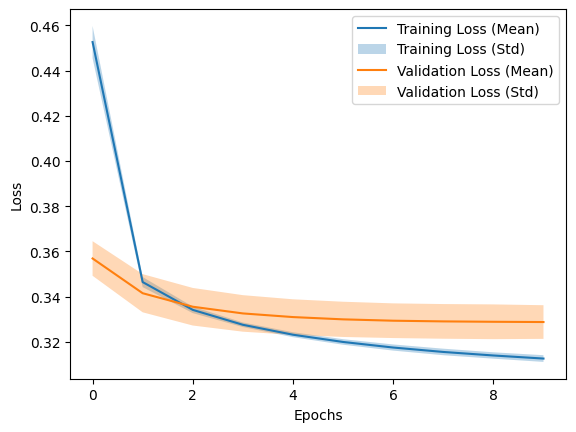

426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


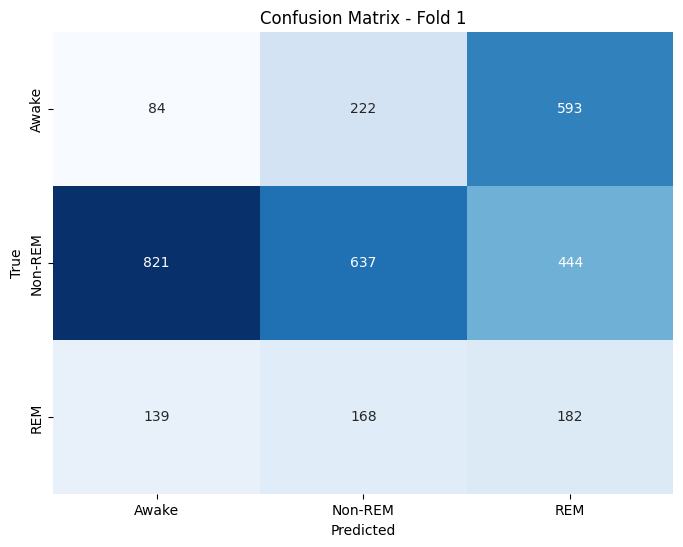

F1 Score - Fold 1: 0.09887222021142672
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


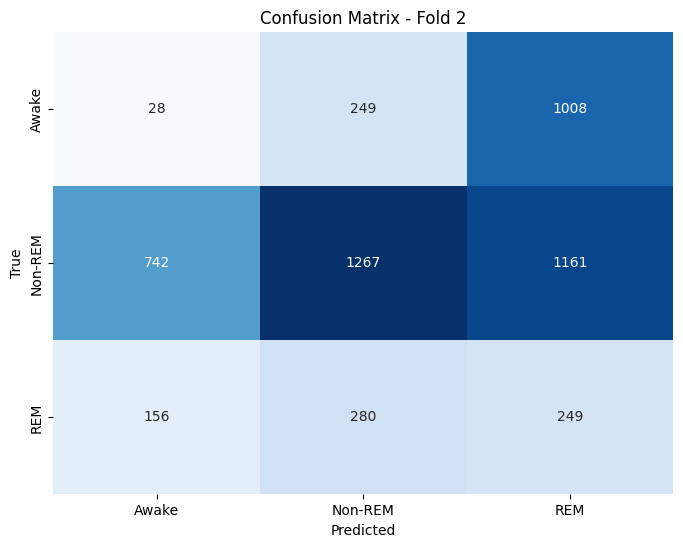

F1 Score - Fold 2: 0.14675893900476475
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


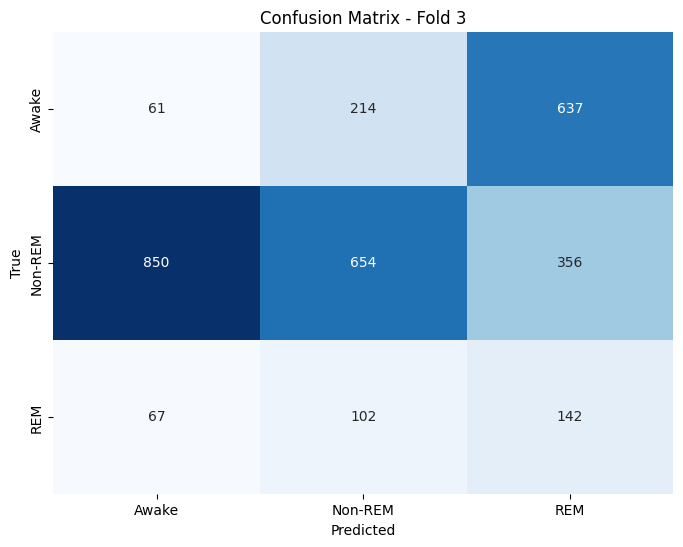

F1 Score - Fold 3: 0.09687581220266042


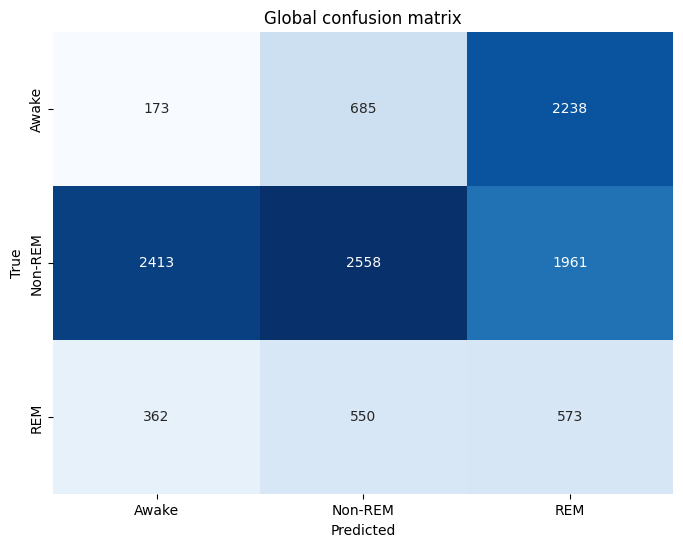

Mean F1 Score across all folds: 0.11416899047295063


In [10]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

#Plot

train_losses = np.array([history.history['loss'] for history in history_list])
val_losses = np.array([history.history['val_loss'] for history in history_list])

# Calculate mean and standard deviation for training and validation losses
mean_train_loss = np.mean(train_losses, axis=0)
std_train_loss = np.std(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)
std_val_loss = np.std(val_losses, axis=0)

# Plot mean and standard deviation for training loss
pl.plot(mean_train_loss, label='Training Loss (Mean)')
pl.fill_between(range(len(mean_train_loss)), mean_train_loss - std_train_loss, mean_train_loss + std_train_loss, alpha=0.3, label='Training Loss (Std)')

# Plot mean and standard deviation for validation loss
pl.plot(mean_val_loss, label='Validation Loss (Mean)')
pl.fill_between(range(len(mean_val_loss)), mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, alpha=0.3, label='Validation Loss (Std)')

# Add labels and legend
pl.xlabel('Epochs')
pl.ylabel('Loss')
pl.legend()

# Display the plot
pl.show()

#Confusion Matrix

def plot_confusion_matrix(confusion_matrix, title):
    # Plot confusion matrix
    pl.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix.astype(int), annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Awake", "Non-REM", "REM"], yticklabels=["Awake", "Non-REM", "REM"])

    pl.title(title)
    pl.xlabel('Predicted')
    pl.ylabel('True')
    pl.show()

f1_scores = []
mean_confusion_matrix = np.zeros((3, 3))

for i, (train_index, test_index) in enumerate(kfold.split(mice_eeg_input)):
    # Evaluate the trained model on the test fold
    predictions = trained_mlp[i].predict(scaler.transform(mice_eeg_input[test_index]))
    #true_labels = (mice_eeg_output[test_index] > 0).astype(int)
    predicted_labels = np.round(predictions).astype(int)[:, 0]
    true_labels = mice_eeg_output[test_index].astype(int)[:, 0]

    # Compute confusion matrix
    #cm = confusion_matrix(true_labels, predictions[::, 0], labels=[0, 1, 2])
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0, 1, 2])
    #mean_confusion_matrix += confusion_matrix(true_labels, predictions[::, 0])
    mean_confusion_matrix += cm

    # Compute confusion matrix and plot
    plot_confusion_matrix(cm, f'Confusion Matrix - Fold {i + 1}')

    # Compute F1 score
    #f1 = f1_score(true_labels, predictions[::, 0])
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    f1_scores.append(f1)
    print(f"F1 Score - Fold {i + 1}: {f1}")

# Plot mean confusion matrix
plot_confusion_matrix(mean_confusion_matrix, 'Global confusion matrix')

# Calculate and display the mean F1 score across all folds
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score across all folds: {mean_f1_score}")